In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import gc
from captum.attr import *
import quantus
import gc
import torchvision.transforms as transforms
import os
import torch.optim as optim
import torchvision.models as models
import sklearn
from sklearn.metrics import roc_auc_score

2024-04-09 11:48:17.068128: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 11:48:17.191384: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-09 11:48:17.191400: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-09 11:48:17.214991: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-09 11:48:17.713890: W tensorflow/stream_executor/platform/de

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
class Network(nn.Module):
    ''' A basic neural network model '''
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()         #python2 : super(MLP, self).__init__()
        #defining the network's operations
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        self.fc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.fc3 = nn.Linear(hidden_size[1], output_size)

    def forward(self, x, softmax=False): 
        x = x.reshape(-1,83)
        a = self.fc3(F.relu(self.fc2(F.relu(self.fc1(x.float())))))
        if softmax:
            y_pred = F.softmax(a, dim=1)
        else:
            y_pred = a
        #print(y_pred.shape)
        return y_pred

In [7]:
input_size = 83
hidden_size=[64,64]
output_size=2
model = Network(input_size, hidden_size, output_size)
model.load_state_dict(torch.load("./model_bce_loss.pytorch"))
model.to(device)

Network(
  (fc1): Linear(in_features=83, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)

In [8]:
class CustomDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.data = self.data.drop(self.data.columns[0], axis=1)  # Remove unnecessary index column
        self.features = self.data.iloc[:, :-1].values  # Features (all columns except the last)
        self.labels = self.data.iloc[:, -1].values     # Labels (last column)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# Load CSV file and split into train and test sets
dataset = CustomDataset('clean_data_before_scaling_class_0.csv')
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [9]:
def make_noise(x_batch, y_batch, spread):
    new_x_batch = []
    for x in x_batch:
        x = x.data.cpu().numpy()
        stdev = spread * (np.max(x)-np.min(x))
        #print(stdev)
        noise = np.random.normal(0, stdev, x.shape).astype(np.float32)
        x_plus_noise = x + noise
        x_plus_noise = np.clip(x_plus_noise, 0, 1)
        x_plus_noise = torch.from_numpy(x_plus_noise).cpu()
        new_x_batch.append(x_plus_noise)
    new_batch = torch.stack(new_x_batch).to(device)
    return new_batch

In [26]:
def compute_metrics_benign(train_loader, normal_model): 
    
    print("Computing metrics for {} for benign")

    
    #attribution robustness
    attribution_gaussian1 = []
    attribution_gaussian2 = []
    attribution_gaussian3 = []
    attribution_gaussian4 = []
    attribution_gaussian5 = []
    
    #logit robustness
    logit_gaussian1 = []
    logit_gaussian2 = []
    logit_gaussian3 = []
    logit_gaussian4 = []
    logit_gaussian5 = []
    
    for step, (x_batch, y_batch) in enumerate(train_loader):
        
        
        images_adv, y_pred_adv = x_batch.to(device), y_batch.to(device)
        x_logits = normal_model(images_adv)
        
        ig = IntegratedGradients(normal_model)
        a_batch = ig.attribute(inputs=images_adv, target=y_pred_adv).to('cpu') 
        #a_batch = quantus.explain(model=normal_model, inputs=images_adv, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        gaussian_noisy_images_1 = make_noise(images_adv, y_pred_adv, spread = 0.0005)
        gaussian_logits_1 = normal_model(gaussian_noisy_images_1)
        
        gaussian_noisy_images_2 = make_noise(images_adv, y_pred_adv, spread = 0.001)
        gaussian_logits_2 = normal_model(gaussian_noisy_images_2)
        
        gaussian_noisy_images_3 = make_noise(images_adv, y_pred_adv, spread = 0.005)
        gaussian_logits_3 = normal_model(gaussian_noisy_images_3)
        
        gaussian_noisy_images_4 = make_noise(images_adv, y_pred_adv, spread = 0.01)
        gaussian_logits_4 = normal_model(gaussian_noisy_images_4)
        
        gaussian_noisy_images_5 = make_noise(images_adv, y_pred_adv, spread = 0.1)
        gaussian_logits_5 = normal_model(gaussian_noisy_images_5)
        
        
        diff1 = torch.norm(x_logits-gaussian_logits_1,p=1, dim=1) 
        diff2 = torch.norm(x_logits-gaussian_logits_2,p=1, dim=1) 
        diff3 = torch.norm(x_logits-gaussian_logits_3,p=1, dim=1) 
        diff4 = torch.norm(x_logits-gaussian_logits_4,p=1, dim=1) 
        diff5 = torch.norm(x_logits-gaussian_logits_5,p=1, dim=1) 
        
        logit_gaussian1.extend(diff1.detach().cpu().numpy())
        logit_gaussian2.extend(diff2.detach().cpu().numpy())
        logit_gaussian3.extend(diff3.detach().cpu().numpy())
        logit_gaussian4.extend(diff4.detach().cpu().numpy())
        logit_gaussian5.extend(diff5.detach().cpu().numpy())
        
        a_batch_gaussian1 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_1, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian2 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_2, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian3 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_3, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian4 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_4, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian5 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_5, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        
        
        for a, b in zip(a_batch, a_batch_gaussian1):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian1.append(c)
            
        for a, b in zip(a_batch, a_batch_gaussian2):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian2.append(c)
        
        for a, b in zip(a_batch, a_batch_gaussian3):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian3.append(c)
            
        for a, b in zip(a_batch, a_batch_gaussian4):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian4.append(c)
        
        for a, b in zip(a_batch, a_batch_gaussian5):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian5.append(c)
        
       
        if step%20==0:
            print(step)
        if step > 20:
            break
        
        
    df = pd.DataFrame([
            
            attribution_gaussian1,
            attribution_gaussian2,
            attribution_gaussian3,
        attribution_gaussian4,
        attribution_gaussian5,
            logit_gaussian1,
            logit_gaussian2,
            logit_gaussian3,
    logit_gaussian4,
    logit_gaussian5], index = [
            "Gaussian1 attribution", 
            "Gaussian2 attribution", 
            "Gaussian3 attribution",
        "Gaussian4 attribution",
        "Gaussian5 attribution",
            "Gaussian1 logit robusntess",
            "Gaussian2 logit robusntess",
            "Gaussian3 logit robusntess",
        "Gaussian4 logit robusntess",
        "Gaussian5 logit robusntess"
                    ])
            
    path = "Benign.csv"
    df.to_csv(path)

In [27]:
compute_metrics_benign(train_loader, model)

Computing metrics for {} for benign
0
20


In [28]:
df_ben = pd.read_csv("Benign.csv")
df_ben

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407
0,Gaussian1 attribution,218357.760276,292546.293220,1.988740e+08,36517.828600,427695.677707,230300.546019,1.264568e+06,466197.973398,4.593204e+08,...,1.054167e+06,457990.286584,1.257112e+09,414419.752112,8.386748e+05,201969.513242,1.041088e+06,1.795666e+06,280234.652907,1.629923e+06
1,Gaussian2 attribution,218185.794196,292516.453832,1.988731e+08,35927.886354,427591.811285,230105.305295,1.264997e+06,466224.200306,4.593199e+08,...,1.054330e+06,457992.303423,1.257112e+09,414385.408440,8.378660e+05,201633.343774,1.042882e+06,1.796138e+06,279921.619311,1.631089e+06
2,Gaussian3 attribution,218417.949979,292408.863017,1.988740e+08,34226.823363,427922.762512,229270.066992,1.264685e+06,466157.794160,4.593208e+08,...,1.053346e+06,458754.810713,1.257112e+09,413993.901615,8.388706e+05,200279.368359,1.041055e+06,1.795755e+06,278869.123262,1.630004e+06
3,Gaussian4 attribution,217299.850478,292679.828183,1.988739e+08,34048.101099,426776.803504,229747.638054,1.264850e+06,466350.633128,4.593204e+08,...,1.053076e+06,457466.051076,1.257112e+09,413787.400402,8.402727e+05,201023.920294,1.042165e+06,1.795337e+06,279771.152869,1.630578e+06
4,Gaussian5 attribution,218687.590431,293720.768444,1.988747e+08,34957.864429,427214.856102,230370.870673,1.264975e+06,466093.801434,4.593203e+08,...,1.051932e+06,457785.807705,1.257112e+09,413335.703733,8.390776e+05,201655.566409,1.041672e+06,1.796467e+06,279298.072584,1.629508e+06
5,Gaussian1 logit robusntess,274357.593750,415075.843750,3.944054e+08,26013.466797,508890.718750,297251.562500,1.995521e+06,495366.437500,7.497373e+08,...,1.564785e+06,693203.062500,2.307862e+09,507405.343750,1.089473e+06,224523.250000,8.587089e+05,1.658646e+06,409030.312500,4.033438e+05
6,Gaussian2 logit robusntess,274361.562500,415038.687500,3.944054e+08,26055.218750,508957.000000,297239.656250,1.995630e+06,495363.812500,7.497373e+08,...,1.564798e+06,693137.750000,2.307862e+09,507389.031250,1.089544e+06,224540.578125,8.586986e+05,1.658648e+06,409075.125000,4.033339e+05
7,Gaussian3 logit robusntess,274359.937500,414999.093750,3.944054e+08,26026.546875,508929.125000,297202.687500,1.995547e+06,495313.812500,7.497373e+08,...,1.564795e+06,693115.250000,2.307862e+09,507416.062500,1.089472e+06,224555.937500,8.586852e+05,1.658641e+06,409086.375000,4.033084e+05
8,Gaussian4 logit robusntess,274316.906250,415023.062500,3.944054e+08,26026.957031,508882.875000,297277.031250,1.995571e+06,495357.750000,7.497373e+08,...,1.564786e+06,693113.562500,2.307862e+09,507451.656250,1.089462e+06,224542.000000,8.586967e+05,1.658676e+06,409047.562500,4.031994e+05
9,Gaussian5 logit robusntess,274345.343750,415015.656250,3.944054e+08,26035.068359,508926.968750,297250.625000,1.995559e+06,495326.281250,7.497373e+08,...,1.564757e+06,693232.875000,2.307862e+09,507392.687500,1.089472e+06,224525.406250,8.586641e+05,1.658640e+06,409096.093750,4.032884e+05


In [29]:
#benign 
attr_gaussian1_benign = df_ben.iloc[0].values.flatten().tolist()[1:]
attr_gaussian2_benign = df_ben.iloc[1].values.flatten().tolist()[1:]
attr_gaussian3_benign = df_ben.iloc[2].values.flatten().tolist()[1:]
attr_gaussian4_benign = df_ben.iloc[3].values.flatten().tolist()[1:]
attr_gaussian5_benign = df_ben.iloc[4].values.flatten().tolist()[1:]

In [30]:
#benign 
logit_gaussian1_benign = df_ben.iloc[5].values.flatten().tolist()[1:]
logit_gaussian2_benign = df_ben.iloc[6].values.flatten().tolist()[1:]
logit_gaussian3_benign = df_ben.iloc[7].values.flatten().tolist()[1:]
logit_gaussian4_benign = df_ben.iloc[8].values.flatten().tolist()[1:]
logit_gaussian5_benign = df_ben.iloc[9].values.flatten().tolist()[1:]

In [31]:
def compute_fpr(ben, t1, t2, ben2, t3, t4): 
    TN=0
    FN=0
    FP = 0 
    TP=0
    
    for value, value2 in zip(ben, ben2): 
        if value < t1 or value >t2:
            FP += 1
        else: 
            if value2 < t3 or value2>t4:
                FP+=1
    
    return (FP/len(ben))*100

In [32]:
min(logit_gaussian1_benign), max(logit_gaussian1_benign)

(26013.466796875, 8682595328.0)

(array([1.213e+03, 7.900e+01, 1.100e+02, 3.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([2.60134668e+04, 8.68282945e+08, 1.73653988e+09, 2.60479681e+09,
        3.47305374e+09, 4.34131067e+09, 5.20956760e+09, 6.07782453e+09,
        6.94608147e+09, 7.81433840e+09, 8.68259533e+09]),
 <BarContainer object of 10 artists>)

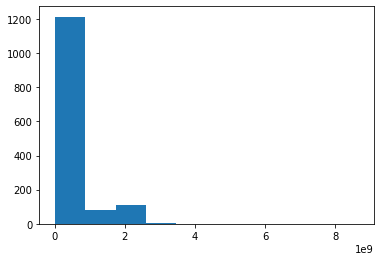

In [33]:
plt.hist(logit_gaussian1_benign)

(array([1.213e+03, 7.900e+01, 1.100e+02, 3.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([2.59678789e+04, 8.68282904e+08, 1.73653984e+09, 2.60479678e+09,
        3.47305371e+09, 4.34131065e+09, 5.20956758e+09, 6.07782452e+09,
        6.94608146e+09, 7.81433839e+09, 8.68259533e+09]),
 <BarContainer object of 10 artists>)

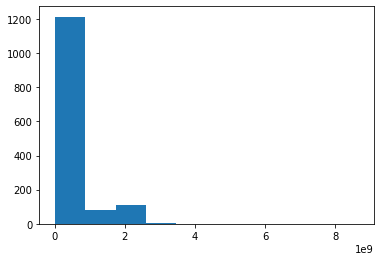

In [34]:
plt.hist(logit_gaussian2_benign)

(array([1.213e+03, 7.900e+01, 1.100e+02, 3.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([2.59864688e+04, 8.68282921e+08, 1.73653985e+09, 2.60479679e+09,
        3.47305372e+09, 4.34131066e+09, 5.20956759e+09, 6.07782453e+09,
        6.94608146e+09, 7.81433839e+09, 8.68259533e+09]),
 <BarContainer object of 10 artists>)

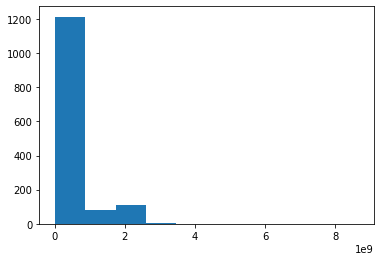

In [35]:
plt.hist(logit_gaussian3_benign)

(array([1.178e+03, 4.600e+01, 1.320e+02, 4.500e+01, 3.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([3.51363917e+04, 4.50751722e+08, 9.01468308e+08, 1.35218489e+09,
        1.80290148e+09, 2.25361806e+09, 2.70433465e+09, 3.15505124e+09,
        3.60576782e+09, 4.05648441e+09, 4.50720099e+09]),
 <BarContainer object of 10 artists>)

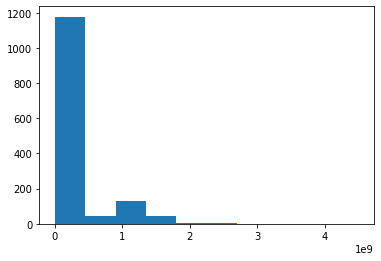

In [36]:
plt.hist(attr_gaussian1_benign)

(array([1.178e+03, 4.600e+01, 1.320e+02, 4.500e+01, 3.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([3.47548198e+04, 4.50751369e+08, 9.01467983e+08, 1.35218460e+09,
        1.80290121e+09, 2.25361782e+09, 2.70433444e+09, 3.15505105e+09,
        3.60576767e+09, 4.05648428e+09, 4.50720089e+09]),
 <BarContainer object of 10 artists>)

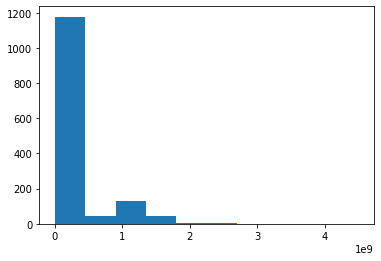

In [37]:
plt.hist(attr_gaussian2_benign)

In [38]:
min(attr_gaussian1_benign), max(attr_gaussian1_benign)

(35136.391737930535, 4507200992.24505)

In [40]:
min(logit_gaussian1_benign), max(logit_gaussian1_benign)

(26013.466796875, 8682595328.0)

In [46]:
t1=[26013,26013,26013]
t2=[8682595000,868259530,86825950]

t3=[35136,35136,35136]
t4=[4507200992,450720090,45072000]
for x, y,a,b in zip(t1,t2,t3,t4):
    print(compute_fpr(logit_gaussian1_benign, x, y, attr_gaussian1_benign, a,b))
    print("---")

0.07102272727272728
---
16.335227272727273
---
29.6875
---


# evaluate detection on adv samples

In [48]:
def compute_metrics_benign(train_loader, normal_model): 
    
    print("Computing metrics for {} for benign")

    
    #attribution robustness
    attribution_gaussian1 = []
    attribution_gaussian2 = []
    attribution_gaussian3 = []
    attribution_gaussian4 = []
    attribution_gaussian5 = []
    
    #logit robustness
    logit_gaussian1 = []
    logit_gaussian2 = []
    logit_gaussian3 = []
    logit_gaussian4 = []
    logit_gaussian5 = []
    
    for step, (x_batch, y_batch) in enumerate(train_loader):
        
        
        images_adv, y_pred_adv = x_batch.to(device), y_batch.to(device)
        x_logits = normal_model(images_adv)
        
        ig = IntegratedGradients(normal_model)
        a_batch = ig.attribute(inputs=images_adv, target=y_pred_adv).to('cpu') 
        
        gaussian_noisy_images_1 = make_noise(images_adv, y_pred_adv, spread = 0.0005)
        gaussian_logits_1 = normal_model(gaussian_noisy_images_1)
        
        gaussian_noisy_images_2 = make_noise(images_adv, y_pred_adv, spread = 0.001)
        gaussian_logits_2 = normal_model(gaussian_noisy_images_2)
        
        gaussian_noisy_images_3 = make_noise(images_adv, y_pred_adv, spread = 0.005)
        gaussian_logits_3 = normal_model(gaussian_noisy_images_3)
        
        gaussian_noisy_images_4 = make_noise(images_adv, y_pred_adv, spread = 0.01)
        gaussian_logits_4 = normal_model(gaussian_noisy_images_4)
        
        gaussian_noisy_images_5 = make_noise(images_adv, y_pred_adv, spread = 0.1)
        gaussian_logits_5 = normal_model(gaussian_noisy_images_5)
        
        
        diff1 = torch.norm(x_logits-gaussian_logits_1,p=1, dim=1) 
        diff2 = torch.norm(x_logits-gaussian_logits_2,p=1, dim=1) 
        diff3 = torch.norm(x_logits-gaussian_logits_3,p=1, dim=1) 
        diff4 = torch.norm(x_logits-gaussian_logits_4,p=1, dim=1) 
        diff5 = torch.norm(x_logits-gaussian_logits_5,p=1, dim=1) 
        
        logit_gaussian1.extend(diff1.detach().cpu().numpy())
        logit_gaussian2.extend(diff2.detach().cpu().numpy())
        logit_gaussian3.extend(diff3.detach().cpu().numpy())
        logit_gaussian4.extend(diff4.detach().cpu().numpy())
        logit_gaussian5.extend(diff5.detach().cpu().numpy())
        
        a_batch_gaussian1 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_1, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian2 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_2, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian3 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_3, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian4 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_4, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian5 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_5, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        
        
        for a, b in zip(a_batch, a_batch_gaussian1):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian1.append(c)
            
        for a, b in zip(a_batch, a_batch_gaussian2):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian2.append(c)
        
        for a, b in zip(a_batch, a_batch_gaussian3):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian3.append(c)
            
        for a, b in zip(a_batch, a_batch_gaussian4):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian4.append(c)
        
        for a, b in zip(a_batch, a_batch_gaussian5):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian5.append(c)
        
       
        if step%20==0:
            print(step)
        if step > 20:
            break
        
        
    df = pd.DataFrame([
            
            attribution_gaussian1,
            attribution_gaussian2,
            attribution_gaussian3,
        attribution_gaussian4,
        attribution_gaussian5,
            logit_gaussian1,
            logit_gaussian2,
            logit_gaussian3,
    logit_gaussian4,
    logit_gaussian5], index = [
            "Gaussian1 attribution", 
            "Gaussian2 attribution", 
            "Gaussian3 attribution",
        "Gaussian4 attribution",
        "Gaussian5 attribution",
            "Gaussian1 logit robusntess",
            "Gaussian2 logit robusntess",
            "Gaussian3 logit robusntess",
        "Gaussian4 logit robusntess",
        "Gaussian5 logit robusntess"
                    ])
            
    path = "Benign_eval.csv"
    df.to_csv(path)

In [49]:
compute_metrics_benign(test_loader, model)

Computing metrics for {} for benign
0
20


In [51]:
def compute_metrics_adv(train_loader, normal_model): 
    
    print("Computing metrics for {} for benign")

    
    #attribution robustness
    attribution_gaussian1 = []
    attribution_gaussian2 = []
    attribution_gaussian3 = []
    attribution_gaussian4 = []
    attribution_gaussian5 = []
    
    #logit robustness
    logit_gaussian1 = []
    logit_gaussian2 = []
    logit_gaussian3 = []
    logit_gaussian4 = []
    logit_gaussian5 = []
    
    for step, (x_batch, y_batch) in enumerate(train_loader):
        
        
        images_adv, y_pred_adv = x_batch.to(device), y_batch.to(device)
        x_logits = normal_model(images_adv)
        
        ig = IntegratedGradients(normal_model)
        a_batch = ig.attribute(inputs=images_adv, target=y_pred_adv).to('cpu') 
        
        gaussian_noisy_images_1 = make_noise(images_adv, y_pred_adv, spread = 0.0005)
        gaussian_logits_1 = normal_model(gaussian_noisy_images_1)
        
        gaussian_noisy_images_2 = make_noise(images_adv, y_pred_adv, spread = 0.001)
        gaussian_logits_2 = normal_model(gaussian_noisy_images_2)
        
        gaussian_noisy_images_3 = make_noise(images_adv, y_pred_adv, spread = 0.005)
        gaussian_logits_3 = normal_model(gaussian_noisy_images_3)
        
        gaussian_noisy_images_4 = make_noise(images_adv, y_pred_adv, spread = 0.01)
        gaussian_logits_4 = normal_model(gaussian_noisy_images_4)
        
        gaussian_noisy_images_5 = make_noise(images_adv, y_pred_adv, spread = 0.1)
        gaussian_logits_5 = normal_model(gaussian_noisy_images_5)
        
        
        diff1 = torch.norm(x_logits-gaussian_logits_1,p=1, dim=1) 
        diff2 = torch.norm(x_logits-gaussian_logits_2,p=1, dim=1) 
        diff3 = torch.norm(x_logits-gaussian_logits_3,p=1, dim=1) 
        diff4 = torch.norm(x_logits-gaussian_logits_4,p=1, dim=1) 
        diff5 = torch.norm(x_logits-gaussian_logits_5,p=1, dim=1) 
        
        logit_gaussian1.extend(diff1.detach().cpu().numpy())
        logit_gaussian2.extend(diff2.detach().cpu().numpy())
        logit_gaussian3.extend(diff3.detach().cpu().numpy())
        logit_gaussian4.extend(diff4.detach().cpu().numpy())
        logit_gaussian5.extend(diff5.detach().cpu().numpy())
        
        a_batch_gaussian1 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_1, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian2 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_2, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian3 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_3, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian4 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_4, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian5 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_5, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        
        
        for a, b in zip(a_batch, a_batch_gaussian1):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian1.append(c)
            
        for a, b in zip(a_batch, a_batch_gaussian2):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian2.append(c)
        
        for a, b in zip(a_batch, a_batch_gaussian3):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian3.append(c)
            
        for a, b in zip(a_batch, a_batch_gaussian4):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian4.append(c)
        
        for a, b in zip(a_batch, a_batch_gaussian5):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian5.append(c)
        
       
        if step%20==0:
            print(step)
        
        
    df = pd.DataFrame([
            
            attribution_gaussian1,
            attribution_gaussian2,
            attribution_gaussian3,
        attribution_gaussian4,
        attribution_gaussian5,
            logit_gaussian1,
            logit_gaussian2,
            logit_gaussian3,
    logit_gaussian4,
    logit_gaussian5], index = [
            "Gaussian1 attribution", 
            "Gaussian2 attribution", 
            "Gaussian3 attribution",
        "Gaussian4 attribution",
        "Gaussian5 attribution",
            "Gaussian1 logit robusntess",
            "Gaussian2 logit robusntess",
            "Gaussian3 logit robusntess",
        "Gaussian4 logit robusntess",
        "Gaussian5 logit robusntess"
                    ])
            
    path = "Adv_eval.csv"
    df.to_csv(path)

In [84]:
# Load CSV file and split into train and test sets
advdataset = CustomDataset('adversarial_examples_FGSM1.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.98, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)

In [85]:
compute_metrics_adv(test_loader_adv, model)

Computing metrics for {} for benign
0


In [86]:
def compute_TPR(adv1, a, b, adv2, c, d): 
    TN=0
    FN=0
    FP = 0 
    TP=0
    
    for value1, value2 in zip(adv1, adv2): 
        if value1<a or value1>b:
            TP += 1
        else:
            if value2<c or value2>d:
                TP+=1
            else: 
                FN+=1
    
    return (TP/(TP+FN))*100

def compute_FPR(ap2a, k, l, ap2b, m, n): 
    TN=0
    FN=0
    FP=0 
    TP=0
    
    for value6, value7 in zip(ap2a,ap2b):
        if value6<k or value6>l:
            FP +=1
        else:
            if value7<m or value7>n:
                FP +=1

    return (FP/(len(ap2a)))*100

In [87]:
k=[26013,26013,26013, 26013, 26013, 26013, 26013]
l=[8682595000,868259530,86825950, 8682595, 868259, 86825, 8682]

m=[35136,35136,35136, 35136, 35136, 35136, 35136]
n=[4507200992,450720090,45072000, 4507200, 450720, 45072, 4507]

In [89]:
score = []
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)

print(fpr_results)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]

tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
print(tpr_results)
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1))

s = sklearn.metrics.auc(fpr_results, tpr_results)
score.append(s)
print(score)

1408 1408
[0.0007102272727272727, 0.17258522727272727, 0.30610795454545453, 0.3899147727272727, 0.7223011363636364, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
980 980
[0.9992897727272728]


In [90]:
# Load CSV file and split into train and test sets
advdataset = CustomDataset('adversarial_examples_FGSM2.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)
score.append(s)

print('---')
# Load CSV file and split into train and test sets
advdataset = CustomDataset('adversarial_examples_FGSM3.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)
score.append(s)

print('---')
# Load CSV file and split into train and test sets
advdataset = CustomDataset('adversarial_examples_FGSM4.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)
score.append(s)

print('---')
# Load CSV file and split into train and test sets
advdataset = CustomDataset('adversarial_examples_FGSM5.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)
score.append(s)

Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200
---
Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200
---
Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200
---
Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200


In [91]:
np.mean(score), np.std(score)

(0.9992897727272728, 0.0)

In [92]:
# Load CSV file and split into train and test sets
score = []
advdataset = CustomDataset('adversarial_examples_autoPGD.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

print('----')
advdataset = CustomDataset('adversarial_examples_autoPGD2.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

print('----')
advdataset = CustomDataset('adversarial_examples_autoPGD3.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

print('----')
advdataset = CustomDataset('adversarial_examples_autoPGD4.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

print('----')
advdataset = CustomDataset('adversarial_examples_autoPGD5.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200
----
Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200
----
Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200
----
Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200
----
Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200


In [93]:
np.mean(score), np.std(score)

(0.9994318181818184, 0.00028409090909087276)

In [94]:
# Load CSV file and split into train and test sets
score = []
advdataset = CustomDataset('adversarial_examples_PGD1.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

print('----')
advdataset = CustomDataset('adversarial_examples_PGD2.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

print('----')
advdataset = CustomDataset('adversarial_examples_PGD3.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

print('----')
advdataset = CustomDataset('adversarial_examples_PGD4.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

print('----')
advdataset = CustomDataset('adversarial_examples_PGD5.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200
----
Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200
----
Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200
----
Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200
----
Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200


In [95]:
np.mean(score), np.std(score)

(0.9997159090909091, 0.0003479388839180206)

In [96]:
# Load CSV file and split into train and test sets
score = []
advdataset = CustomDataset('adversarial_examples_BIM1.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

print('----')
advdataset = CustomDataset('adversarial_examples_BIM2.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

print('----')
advdataset = CustomDataset('adversarial_examples_BIM3.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

print('----')
advdataset = CustomDataset('adversarial_examples_BIM4.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

print('----')
advdataset = CustomDataset('adversarial_examples_BIM5.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200
----
Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200
----
Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200
----
Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200
----
Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200


In [97]:
np.mean(score), np.std(score)

(0.9997159090909091, 0.0003479388839180206)

In [98]:
# Load CSV file and split into train and test sets
score = []
advdataset = CustomDataset('adversarial_examples_CW1.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

print('----')
advdataset = CustomDataset('adversarial_examples_CW2.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

print('----')
advdataset = CustomDataset('adversarial_examples_CW3.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

print('----')
advdataset = CustomDataset('adversarial_examples_CW4.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

print('----')
advdataset = CustomDataset('adversarial_examples_CW5.csv')
advtrain_data, advtest_data = train_test_split(advdataset, test_size=0.2, random_state=42)

# Create data loaders for training and testing
batch_size = 64
train_loader_adv = DataLoader(advtrain_data, batch_size=batch_size, shuffle=True)
test_loader_adv = DataLoader(advtest_data, batch_size=batch_size, shuffle=False)
compute_metrics_benign(test_loader, model)
compute_metrics_adv(test_loader_adv, model)
df_ben = pd.read_csv("Benign_eval.csv")
attr_gaussian3 = df_ben.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3 = df_ben.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3), len(logit_gaussian3))
fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
df_adv= pd.read_csv("Adv_eval.csv")
attr_gaussian3_eps1 = df_adv.iloc[0].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_adv.iloc[5].values.flatten().tolist()[1:]
print(len(attr_gaussian3_eps1), len(logit_gaussian3_eps1)) 
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
s = sklearn.metrics.auc(fpr_results, tpr_results)  
score.append(s)

Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200
----
Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200
----
Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200
----
Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200
----
Computing metrics for {} for benign
0
20
Computing metrics for {} for benign
0
1408 1408
200 200


In [99]:
np.mean(score), np.std(score)

(0.9997159090909091, 0.0003479388839180206)